In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

#display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

# Toggle cell visibility
from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Promijeni vidljivost <a href="javascript:code_toggle()">ovdje</a>.''')
display(tag)


## Dizajn upravljanja za sustav pozicioniranja s kugličnim vijkom na pogon DC motora

Ovaj primjer predstavlja zadatak dizajniranja upravljačkog mehanizma za sustav pozicioniranja s kugličnim vijkom na pogon DC motora. Konstrukcija se sastoji od istosmjernog motora povezanog s kugličnim vijkom koji pokreće kolica. Model obuhvaća veliki skup komponenata. Nakon niza pojednostavljenja, može se svesti na linearni model s deset parametara.
<br>
Motor se može modelirati u dva odvojena dijela, električki i mehanički:
<br><br>
$$G_{elec}(s)=\frac{1}{sL+R}\qquad\qquad G_{mech}=\frac{1}{sJ+B}$$
<br><br>
<img src="Images/ballscrew.png" width="40%" />
<br>
Kuglični vijak s kolicima može se opisati sljedećom prijenosnom funkcijom:
<br><br>
$$G_{ballscrew}(s)=\frac{\frac{h}{2\pi}}{s^2 m\left(\frac{1}{K}+\frac{1}{k}\right)+sb\left(\frac{1}{K}+\frac{1}{k}\right)+1}$$
<br><br>
<center>
$h:$ korak navoja<br>
$K:$ konstanta torzijske opruge vratila<br>
$k:$ konstanta kombinirane linearne opruge<br>
$b:$ kombinirano prigušenje<br>
$m:$ masa kolica
</center>
<br>
Vaš je zadatak odabrati tip regulatora i prilagoditi ga prihvatljivoj razini izvedbe!

<b>Prvo, odaberite model sustava!</b>

<IPython.core.display.Javascript object>


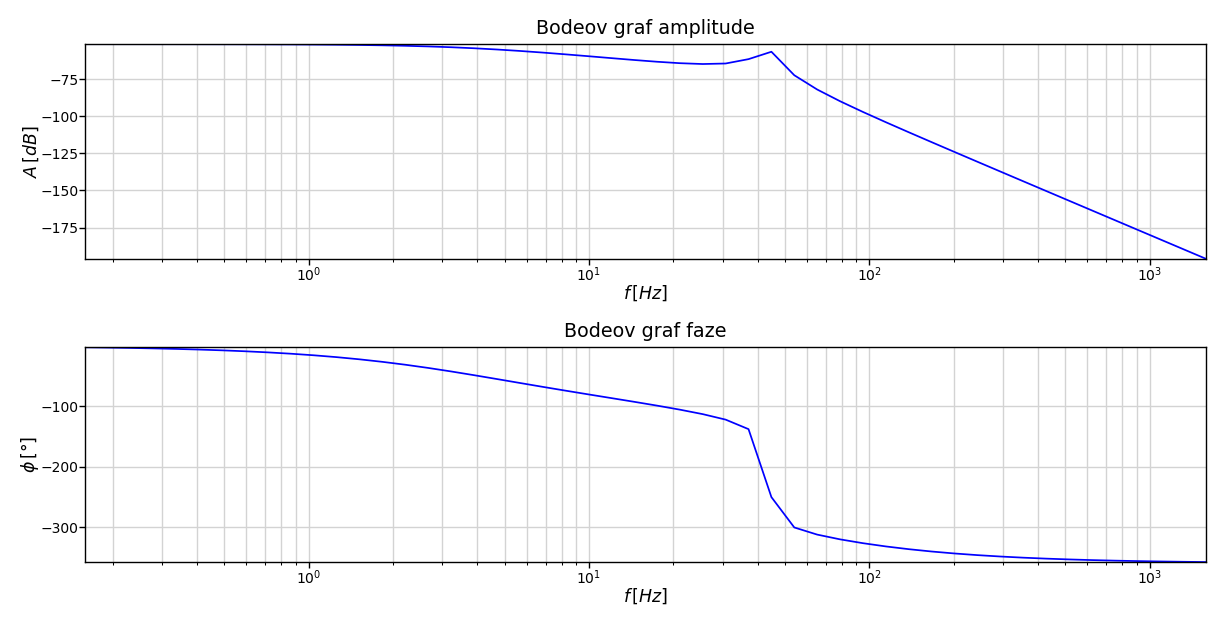

ToggleButtons(description='Sustav: ', index=6, layout=Layout(width='60%'), options=(('Model 1', 0), ('Model 2'…

Output()

In [2]:
# System parameters

# Motor parameters
R = 0.5      # Ohm - armature resistance
L = 1.5e-3   # H - armature inductance
J = 2.5e-4   # kgm^2 - rotor inertia
B = 1.0e-3   # Nms - friction as damping
kPhi = 0.05  # Nm/A or Vs/rad - Torque/back EMF constant

# Ballscrew parameters
h = [0.8, 1.0, 1.25, 0.8, 1.0, 1.25, 0.8]     # mm - thread pitch
K = [2e5, 0.5e5, 1e6, 1e6, 2e5, 0.5e5, 5e5]   # Nm/rad - shaft torsional spring constant
k = [1e4, 4e4, 3e4, 1e4, 3e4, 4e4, 2e4]       # N/m - combined spring constants
b = [2, 8, 5, 3, 2, 10, 8]                    # Ns/m - combined damping
m = [0.5, 0.3, 1.5, 0.1, 0.75, 1, 1]          # kg - cart mass

# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [])
f1_line2, = f1_ax2.plot([], [])  

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='both', tight=True)
f1_ax2.autoscale(enable=True, axis='both', tight=True)

f1_ax1.set_title('Bodeov graf amplitude', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/[Hz]$', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/[dB]$', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bodeov graf faze', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/[Hz]$', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/[°]$', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

def build_base_model(sel):
    
    # DC motor model
    
    W_v = c.tf([1], [L, R])   # Electrical part
    W_m = c.tf([1], [J, B])   # Mechanical part
    W_e = c.tf([kPhi], [1])   # Back EMF component
    
    W_motor = c.feedback(c.series(W_v, W_e, W_m), W_e, -1)   # Motor transfer function
    
    # Ballscrew model
    
    p_num = [h[sel]*1e-3/(2*np.pi)]
    p_den = [(1/K[sel]+1/k[sel])*m[sel], (1/K[sel]+1/k[sel])*b[sel], 1]
    
    W_ballscrew = c.tf(p_num, p_den)
    
    # Complete system model
    
    W_sys = c.series(W_motor, W_ballscrew)
    
    print('Prijenosna funkcija sustava:')
    print(W_sys)
    
    # System analysis
    
    poles = c.pole(W_sys)     # Poles
    
    print('Polovi sustava:\n')
    print(poles)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    
    mag, phase, omega = c.bode_plot(W_sys, Plot=False)   # Bode-plot
    
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   
    
    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
# GUI widgets
typeSelect = w.ToggleButtons(
    options=[('Model 1', 0), ('Model 2', 1), ('Model 3', 2), ('Model 4', 3), ('Model 5', 4), ('Model 6', 5), ('Reset', -1)],
    value=-1, description='Sustav: ', layout=w.Layout(width='60%'))

input_data = w.interactive_output(build_base_model, {'sel':typeSelect})

display(typeSelect, input_data)    

Sustav ima više polova nego što možete eliminirati pomoću PID regulatora; morate odabrati koje ćete izmijeniti, dok će ostatak ostati nepromijenjen.<br>
<b>Odaberite odgovarajuću konfiguraciju regulatora! Koja je najbolja za vaš sustav? Zašto?<br>
Postavite svoj regulator za najbrže vrijeme smirivanja bez prisustva prekoračenja!</b>

Možete uključiti / isključiti svaku od I i D komponenata, a ako je D aktivna, možete primijeniti i filtar prvog reda, na temelju deriviranja vremenske konstante.



<IPython.core.display.Javascript object>


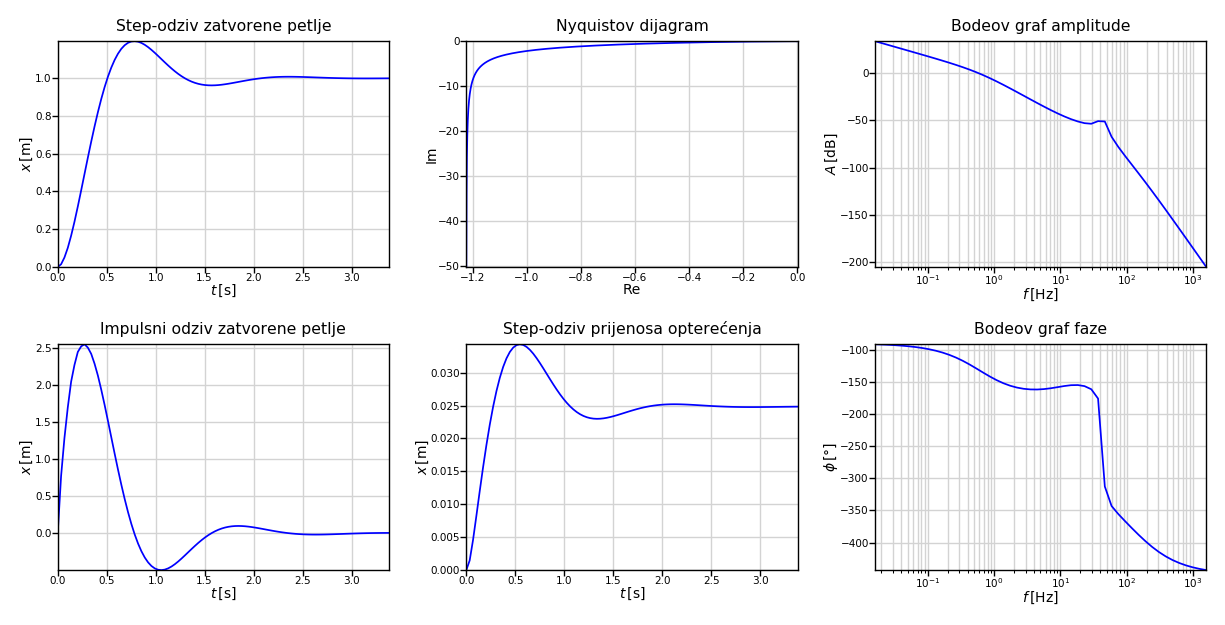

Output()

In [3]:
# PID position control

fig2, ((f2_ax1, f2_ax2, f2_ax3), (f2_ax4, f2_ax5, f2_ax6)) = plt.subplots(2, 3)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

f2_line1, = f2_ax1.plot([], [])
f2_line2, = f2_ax2.plot([], []) 
f2_line3, = f2_ax3.plot([], [])
f2_line4, = f2_ax4.plot([], [])  
f2_line5, = f2_ax5.plot([], [])
f2_line6, = f2_ax6.plot([], [])

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')
f2_ax3.grid(which='both', axis='both', color='lightgray')
f2_ax4.grid(which='both', axis='both', color='lightgray')
f2_ax5.grid(which='both', axis='both', color='lightgray')
f2_ax6.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='both', tight=True)
f2_ax2.autoscale(enable=True, axis='both', tight=True)
f2_ax3.autoscale(enable=True, axis='both', tight=True)
f2_ax4.autoscale(enable=True, axis='both', tight=True)
f2_ax5.autoscale(enable=True, axis='both', tight=True)
f2_ax6.autoscale(enable=True, axis='both', tight=True)


f2_ax1.set_title('Step-odziv zatvorene petlje', fontsize=9)
f2_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax2.set_title('Nyquistov dijagram', fontsize=9)
f2_ax2.set_xlabel(r'Re', labelpad=0, fontsize=8)
f2_ax2.set_ylabel(r'Im', labelpad=0, fontsize=8)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax3.set_title('Bodeov graf amplitude', fontsize=9)
f2_ax3.set_xscale('log')
f2_ax3.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax3.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=8)
f2_ax3.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax4.set_title('Impulsni odziv zatvorene petlje', fontsize=9)
f2_ax4.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax4.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax4.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax5.set_title('Step-odziv prijenosa opterećenja', fontsize=9)
f2_ax5.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax5.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax5.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax6.set_title('Bodeov graf faze', fontsize=9)
f2_ax6.set_xscale('log')
f2_ax6.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax6.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=8)
f2_ax6.tick_params(axis='both', which='both', pad=0, labelsize=6)

def position_control(Kp, Ti, Td, Fd, Ti0, Td0, Fd0, sel):
    
    W_motor = c.series(c.tf([1], [L, R]), c.tf([1], [J, B]), c.tf([kPhi], [1]))
    W_ballscrew = c.tf([h[sel]*1e-3/(2*np.pi)], [(1/K[sel]+1/k[sel])*m[sel], (1/K[sel]+1/k[sel])*b[sel], 1])
    W_sys = c.series(W_motor, W_ballscrew)
    
    # PID Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td / Fd     # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller in time constant format
    
    W_open = c.series(W_PID, W_sys, c.tf([1], [1, 0]))   # Open loop with integrator added for position output
    W_closed = c.feedback(W_open, 1, -1)                 # Closed loop with negative feedback
    
    W_cart = c.tf([1],[m[sel], b[sel]])                                        # Ballscrew ring transfer function component
    W_rest = c.series(W_open, c.tf([m[sel], b[sel]], [1]), c.tf([1, 0], [1]))  # The system without the cart and the integrator
    W_load = c.feedback(c.series(W_cart, c.tf([1], [1, 0])), W_rest, -1)       # Transfer function of the load based errors  
                        
    # Display

    global f2_line1, f2_line2, f2_line3, f2_line4, f2_line5, f2_line6
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax3.lines.remove(f2_line3)
    f2_ax4.lines.remove(f2_line4)
    f2_ax5.lines.remove(f2_line5)
    f2_ax6.lines.remove(f2_line6)
    
    tout, yout = c.step_response(W_closed)
    f2_line1, = f2_ax1.plot(tout, yout, lw=1, color='blue') 
    
    _, _, ob = c.nyquist_plot(W_open, Plot=False)   # Small resolution plot to determine bounds        
    real, imag, freq = c.nyquist_plot(W_open, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 1000), Plot=False)
    f2_line2, = f2_ax2.plot(real, imag, lw=1, color='blue')
    
    mag, phase, omega = c.bode_plot(W_open, Plot=False)
    f2_line3, = f2_ax3.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line6, = f2_ax6.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')
    
    tout, yout = c.impulse_response(W_closed)
    f2_line4, = f2_ax4.plot(tout, yout, lw=1, color='blue')   
    
    tout, yout = c.step_response(W_load)
    f2_line5, = f2_ax5.plot(tout, yout, lw=1, color='blue')  
    
    f2_ax1.relim()
    f2_ax2.relim()
    f2_ax3.relim()
    f2_ax4.relim()
    f2_ax5.relim()
    f2_ax6.relim()
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    f2_ax3.autoscale_view()
    f2_ax4.autoscale_view()
    f2_ax5.autoscale_view()
    f2_ax6.autoscale_view()
    
def update_controller(index):
    global Kp_slider, Ti_slider, Td_slider, Fd_slider, Ti_button, Td_button, Fd_button
    
    if index == -1:
        Kp_slider.value = 200
        Td_slider.value = 0.01
        Fd_slider.value = 10
        Ti_button.value = False
        Td_button.value = True
        Fd_button.value = True
        
        Kp_slider.disabled = True
        Ti_slider.disabled = True
        Td_slider.disabled = True
        Fd_slider.disabled = True
        Ti_button.disabled = True
        Td_button.disabled = True
        Fd_button.disabled = True
    else:
        Kp_slider.disabled = False
        Ti_slider.disabled = False
        Td_slider.disabled = False
        Fd_slider.disabled = False
        Ti_button.disabled = False
        Td_button.disabled = False
        Fd_button.disabled = False
    
    
# Controllers

Kp_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Kp:', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))
Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='', continuous_update=False,
                             layout=w.Layout(width='auto', flex='5 5 auto'))

Ti_button = w.ToggleButton(value=True, description='Ti',
                           layout=w.Layout(width='auto', flex='1 1 0%'))
Td_button = w.ToggleButton(value=False, description='Td',
                           layout=w.Layout(width='auto', flex='1 1 0%'))
Fd_button = w.ToggleButton(value=False, description='Fd',
                           layout=w.Layout(width='auto', flex='1 1 0%'))

input_data = w.interactive_output(position_control, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                                 'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                                 'Fd0': Fd_button, 'sel':typeSelect})

w.interactive_output(update_controller, {'index':typeSelect})

display(w.HBox([Kp_slider, Ti_button, Ti_slider, Td_button, Td_slider, Fd_button, Fd_slider]), input_data)

U sljedećoj simulaciji možete promatrati kretanje sustava zasnovano na postavkama vašeg regulatora. Možete stvoriti referentne signale, pa čak i primijeniti neke smetnje te vidjeti kako sustav reagira.

<b> Je li vaša konfiguracija prikladna za praćenje signala? Prilagodite svoj regulator na način da može prihvatljivo pratiti sinusni val! </b>
<br> <br>
<i>(Animacije se skaliraju na način da odgovaraju prikaznom okviru tijekom cijele simulacije. Zbog toga se može činiti da se nestabilna rješenja ne pomiču sve do posljednje sekunde.) </i>

<IPython.core.display.Javascript object>


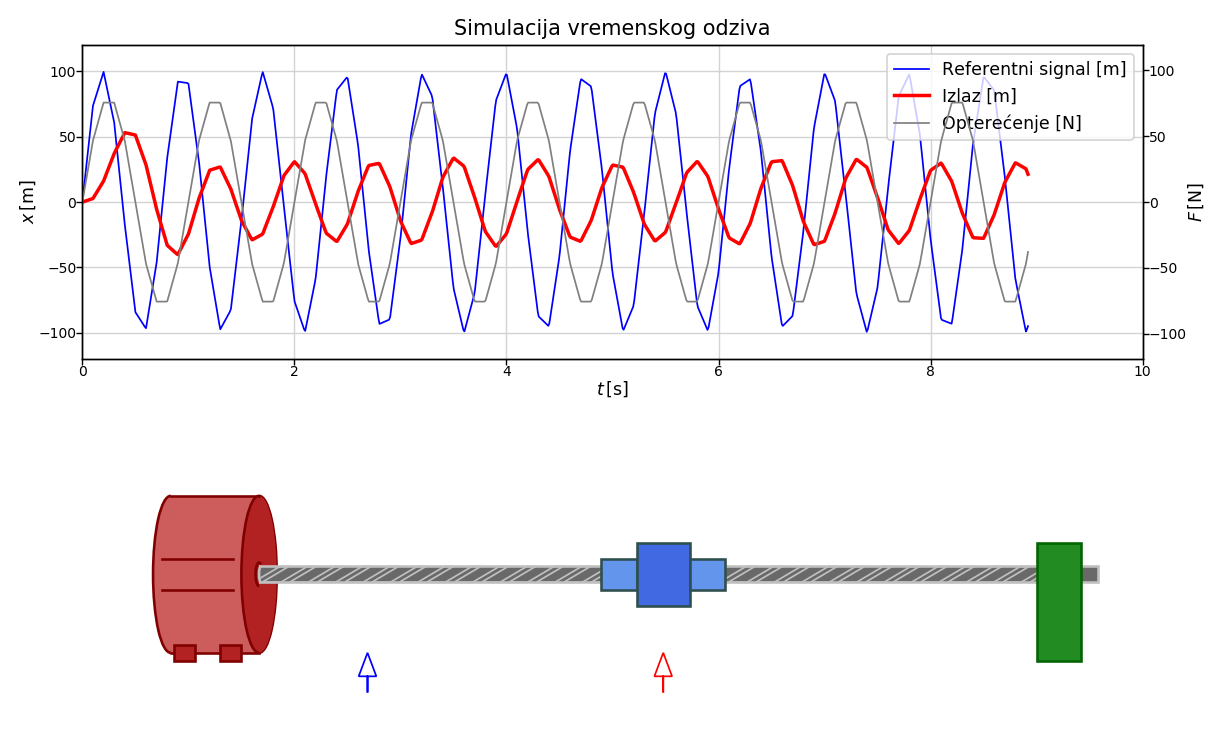

Output()

In [4]:
# Simulation data

anim_fig = plt.figure()
anim_fig.set_size_inches((9.8, 6))
anim_fig.set_tight_layout(True)

anim_ax1 = anim_fig.add_subplot(211)
anim_ax2 = anim_ax1.twinx()

frame_count=1000

l1 = anim_ax1.plot([], [], lw=1, color='blue')
l2 = anim_ax1.plot([], [], lw=2, color='red')
l3 = anim_ax2.plot([], [], lw=1, color='grey')

line1 = l1[0]
line2 = l2[0]
line3 = l3[0]

anim_ax1.legend(l1+l2+l3, ['Referentni signal [m]', 'Izlaz [m]', 'Opterećenje [N]'], loc=1)

anim_ax1.set_title('Simulacija vremenskog odziva', fontsize=12)
anim_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=10)
anim_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=10)
anim_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)
anim_ax2.set_ylabel(r'$F\/$[N]', labelpad=0, fontsize=10)
anim_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

anim_ax1.grid(which='both', axis='both', color='lightgray')

T_plot = []
U_plot = []
F_plot = []
R_plot = []

# Scene data

scene_ax = anim_fig.add_subplot(212)
scene_ax.set_xlim((-3, 3))
scene_ax.set_ylim((-1, 1))
scene_ax.axis('off')


scene_ax.add_patch(patches.Ellipse((-2.5, 0), 0.2, 1, fill=True, fc='indianred', lw=0, zorder=0))
scene_ax.add_patch(patches.Ellipse((-2, 0), 0.2, 1, fill=True, fc='firebrick', lw=0, zorder=5))
scene_ax.add_patch(patches.Rectangle((-2.5, -0.5), 0.5, 1, fill=True, fc='indianred', lw=0, zorder=0))
scene_ax.add_patch(patches.Arc((-2.5, 0), 0.2, 1, theta1=90, theta2=270, color='maroon', lw=1.5, zorder=10))
scene_ax.add_patch(patches.Arc((-2, 0), 0.2, 1, theta1=90, theta2=270, color='maroon', lw=1.5, zorder=30))
scene_ax.add_patch(patches.Arc((-2, 0), 0.2, 1, theta1=270, theta2=90, color='maroon', lw=1.5, zorder=0))
scene_ax.add_patch(patches.Rectangle((-2.48, -0.55), 0.12, 0.1, fill=True, ec='maroon', fc='firebrick', lw=1.5, zorder=15))
scene_ax.add_patch(patches.Rectangle((-2.22, -0.55), 0.12, 0.1, fill=True, ec='maroon', fc='firebrick', lw=1.5, zorder=15))
scene_ax.plot([-2.5, -2], [-0.5, -0.5], color='maroon', lw=1.5, zorder=5)
scene_ax.plot([-2.5, -2], [0.5, 0.5], color='maroon', lw=1.5, zorder=5)
scene_ax.plot([-2.55, -2.15], [-0.1, -0.1], color='maroon', lw=1.5, zorder=5)
scene_ax.plot([-2.55, -2.15], [0.1, 0.1], color='maroon', lw=1.5, zorder=5)

scene_ax.add_patch(patches.Rectangle((2.4, -0.55), 0.25, 0.75, fill=True, ec='darkgreen', fc='forestgreen', lw=1.5, zorder=25))
scene_ax.add_patch(patches.Rectangle((-2.1, -0.075), 0.1, 0.15, fill=True, fc='firebrick', lw=0, zorder=25))
scene_ax.add_patch(patches.Rectangle((-2.2, -0.075), 0.1, 0.15, fill=True, fc='indianred', lw=0, zorder=25))
scene_ax.add_patch(patches.Rectangle((-2.15, -0.05), 4.9, 0.1, fill=True, ec='silver',
                                     fc='dimgrey', lw=1.5, zorder=10))
scene_ax.add_patch(patches.Arc((-1.99, 0), 0.02, 0.1, theta1=90, theta2=270, color='silver', lw=1.5, zorder=30))
scene_ax.add_patch(patches.Arc((-2, 0), 0.04, 0.15, theta1=80, theta2=270, color='maroon', lw=1.5, zorder=30))

screw_base_x = np.tile([0, 0.15, 0.2, 0.05], 30) + np.repeat(np.linspace(0, 4.5, 30), 4)
screw_base_y = np.tile([-0.05, 0.05, 0.05, -0.05], 30)
screw, = scene_ax.plot(screw_base_x - 2.2, screw_base_y, color='silver', lw=1, zorder=15)

cart_1 = patches.Rectangle((-0.35, -0.1), 0.2, 0.2, fill=True, ec='darkslategray', fc='cornflowerblue', lw=1.5, zorder=35)
cart_2 = patches.Rectangle((-0.15, -0.3), 0.3, 0.4, fill=True, ec='darkslategray', fc='royalblue', lw=1.5, zorder=35)
cart_3 = patches.Rectangle((0.15, -0.1), 0.2, 0.2, fill=True, ec='darkslategray', fc='cornflowerblue', lw=1.5, zorder=35)
scene_ax.add_patch(cart_1)
scene_ax.add_patch(cart_2)
scene_ax.add_patch(cart_3)

u_arrow = scene_ax.arrow(0, -0.75, 0, 0.25, color='blue', head_width=0.1,
                         length_includes_head=True, lw=1, fill=False, zorder=10)
r_arrow = scene_ax.arrow(0, -0.75, 0, 0.25, color='red', head_width=0.1,
                         length_includes_head=True, lw=1, fill=False, zorder=10)
base_arrow = u_arrow.xy

pos_var = []
ref_var = []
    
#Simulation function

def simulation(Kp, Ti, Td, Fd, Ti0, Td0, Fd0, sel, T, dt, U, Uf, Ua, Uo, F, Ff, Fa, Fo):
    
    # Controller
    P = Kp            # Proportional term
    I = Kp / Ti       # Integral term
    D = Kp * Td       # Derivative term
    Td_f = Td / Fd    # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller
    
    
    # System
    W_motor = c.series(c.tf([1], [L, R]), c.tf([1], [J, B]), c.tf([kPhi], [1]))
    W_ballscrew = c.tf([h[sel]*1e-3/(2*np.pi)], [(1/K[sel]+1/k[sel])*m[sel], (1/K[sel]+1/k[sel])*b[sel], 1])
    W_sys = c.series(W_motor, W_ballscrew)
    
    # Model
    W_open = c.series(W_PID, W_sys, c.tf([1], [1, 0]))   # Open loop with integrator added for position output
    W_closed = c.feedback(W_open, 1, -1)                 # Closed loop with negative feedback
    
    W_cart = c.tf([1],[m[sel], b[sel]])                                        # Ballscrew ring transfer function component
    W_rest = c.series(W_open, c.tf([m[sel], b[sel]], [1]), c.tf([1, 0], [1]))  # The system without the cart and the integrator
    W_load = c.feedback(c.series(W_cart, c.tf([1], [1, 0])), W_rest, -1)       # Transfer function of the load based errors 
    
    # Reference and disturbance signals

    T_sim = np.arange(0, T, dt, dtype=np.float64)
    
    if U == 0:     # Constant reference
        U_sim = np.full_like(T_sim, Ua * Uo)
    elif U == 1:   # Sine wave reference
        U_sim = (np.sin(2 * np.pi * Uf * T_sim) + Uo) * Ua
    elif U == 2:   # Square wave reference
        U_sim = (np.sign(np.sin(2 * np.pi * Uf * T_sim)) + Uo) * Ua
        
    if F == 0:     # Constant load
        F_sim = np.full_like(T_sim, Fa * Fo)
    elif F == 1:   # Sine wave load
        F_sim = (np.sin(2 * np.pi * Ff * T_sim) + Fo) * Fa
    elif F == 2:   # Square wave load
        F_sim = (np.sign(np.sin(2 * np.pi * Ff * T_sim)) + Fo) * Fa
    elif F == 3:   # Noise form load
        F_sim = np.interp(T_sim, np.linspace(0, T, int(T * Ff) + 2),
                          np.random.normal(loc=(Fo * Fa), scale=Fa, size=int(T * Ff) + 2))
    
    # System response
        
    Tu, youtu, xoutu = c.forced_response(W_closed, T_sim, U_sim)
    Tf, youtf, xoutf = c.forced_response(W_load, T_sim, F_sim)
    R_sim = np.nan_to_num(youtu + youtf)
    
    # Display
            
    UR_max = max(np.amax(np.absolute(np.concatenate((U_sim, R_sim)))), Ua)
    F_max = max(np.amax(np.absolute(F_sim)), Fa)
    
    anim_ax1.set_xlim((0, T))
    anim_ax1.set_ylim((-1.2 * UR_max, 1.2 * UR_max))
    anim_ax2.set_ylim((-1.5 * F_max, 1.5 * F_max))
    
    global T_plot, U_plot, F_plot, R_plot, pos_var, ref_var
    
    T_plot = np.linspace(0, T, frame_count, dtype=np.float32)
    U_plot = np.interp(T_plot, T_sim, U_sim)
    F_plot = np.interp(T_plot, T_sim, F_sim)
    R_plot = np.interp(T_plot, T_sim, R_sim)
    
    pos_var = R_plot/UR_max
    ref_var = U_plot/UR_max
    

def anim_init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
    screw.set_data(screw_base_x - 2.2, screw_base_y)
    
    cart_1.set_xy((-0.35, -0.1))
    cart_2.set_xy((-0.15, -0.2))
    cart_3.set_xy((0.15, -0.1))
    
    u_arrow.set_xy(base_arrow)
    r_arrow.set_xy(base_arrow)

    return (line1, line2, line3, screw, cart_1, cart_2, cart_3, u_arrow, r_arrow,)

def animate(i):
    line1.set_data(T_plot[0:i], U_plot[0:i])
    line2.set_data(T_plot[0:i], R_plot[0:i])
    line3.set_data(T_plot[0:i], F_plot[0:i])
    
    screw_shift = 1 - np.remainder(pos_var[i] * 10, 1)
    screw.set_data(screw_base_x - 2.2 + 0.15 * screw_shift, screw_base_y)
    
    cart_1.set_x(pos_var[i] * 1.5 - 0.35)
    cart_2.set_x(pos_var[i] * 1.5 - 0.15)
    cart_3.set_x(pos_var[i] * 1.5 + 0.15)
    
    u_arrow.set_xy(base_arrow+[ref_var[i] * 1.5, 0])
    r_arrow.set_xy(base_arrow+[pos_var[i] * 1.5, 0])
    
    return (line1, line2, line3, screw, cart_1, cart_2, cart_3, u_arrow, r_arrow,)

anim = animation.FuncAnimation(anim_fig, animate, init_func=anim_init,
                               frames=frame_count, interval=10, blit=True,
                               repeat=True)

# Controllers

T_slider = w.FloatLogSlider(value=10, base=10, min=-0.7, max=1, step=0.01,
                            description='Trajanje [s]:', continuous_update=False,
                            orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

dt_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=-1, step=0.01,
                             description='Vremenski korak [s]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
       
U_type = w.Dropdown(options=[('Konstanta', 0), ('Sinusni signal', 1), ('Pravokutni signal', 2)], value=1,
                     description='Referentni signal: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Uf_slider = w.FloatLogSlider(value=0.5, base=10, min=-2, max=2, step=0.01,
                             description='Frekvencija [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Ua_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Amplituda [m]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Uo_slider = w.FloatSlider(value=0, min=-10, max=10, description='Pomak/Ampl:', continuous_update=False,
                              orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))    
    
F_type = w.Dropdown(options=[('Konstanta', 0), ('Sinusni signal', 1), ('Pravokutni signal', 2), ('Šum', 3)], value=2,
                     description='Smetnja: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Ff_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Frekvencija [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Fa_slider = w.FloatLogSlider(value=0.1, base=10, min=-2, max=2, step=0.01,
                             description='Amplituda [N]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Fo_slider = w.FloatSlider(value=0, min=-10, max=10, description='Pomak/Ampl:', continuous_update=False,
                              orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

input_data = w.interactive_output(simulation, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                               'Fd': Fd_slider, 'Ti0' : Ti_button, 'Td0': Td_button,
                                               'Fd0': Fd_button, 'sel':typeSelect,
                                               'T': T_slider, 'dt': dt_slider,
                                               'U': U_type, 'Uf': Uf_slider, 'Ua': Ua_slider, 'Uo': Uo_slider,
                                               'F': F_type, 'Ff': Ff_slider, 'Fa': Fa_slider, 'Fo': Fo_slider})

display(w.HBox([w.HBox([T_slider, dt_slider], layout=w.Layout(width='25%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([U_type, w.HBox([Uf_slider, Ua_slider, Uo_slider])], layout=w.Layout(width='30%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([F_type, w.HBox([Ff_slider, Fa_slider, Fo_slider])], layout=w.Layout(width='30%'))],
                layout=w.Layout(width='100%', justify_content='center')), input_data)

Parametar trajanja kontrolira simulirani vremenski okvir i ne utječe na vrijeme izvođenja animacije. Suprotno tome, vremenski korak kontrolira uzorkovanje modela i može poboljšati rezultate, ali uz veće zahtjeve na računalne resurse.